In [1]:
%load_ext autoreload
%autoreload 2

import gym, ray

import os
import fmuSimulation.gymFMU as ExampleFMU
from fmuSimulation.configReader import configReader
import numpy as np
import sys

config = os.path.abspath('Example.cfg')
cfg = configReader(config)
config = cfg.getAgent()
env = ExampleFMU.gymFMU(config['env_config'])

import numpy as np
import torch
import gym
import argparse
import os

import utils
import TD3



# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
	eval_env = gym.make(env_name)
	eval_env.seed(seed + 100)

	avg_reward = 0.
	for _ in range(eval_episodes):
		state, done = eval_env.reset(), False
		while not done:
			action = policy.select_action(np.array(state))
			state, reward, done, _ = eval_env.step(action)
			avg_reward += reward

	avg_reward /= eval_episodes

	print("---------------------------------------")
	print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
	print("---------------------------------------")
	return avg_reward



No function for resetIO implemented
No function for obsProcessing implemented
Incompatible sample time and stop time.
 Using 10.0 as stop time instead


In [2]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005,
}

max_timesteps = int(1e6)
start_timesteps = int(25e3)
expl_noise = 0.1
max_episode_steps = 1e10
batch_size = 128
eval_freq = 2

policy_noise = 0.2
noise_clip = 0.5
policy_freq = 2
# Target policy smoothing is scaled wrt the action scale
kwargs["policy_noise"] = policy_noise * max_action
kwargs["noise_clip"] = noise_clip * max_action
kwargs["policy_freq"] = policy_freq

policy = TD3.TD3(**kwargs)
#evaluations = [eval_policy(policy, args.env, args.seed)]

In [4]:
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

max_timesteps = int(2e6)
for t in range(int(max_timesteps)):
    
    episode_timesteps += 1

    # Select action randomly or according to policy
   # if t < start_timesteps:
    #    action = env.action_space.sample()
    #else:
     #   action = (
      #      policy.select_action(np.array(state))
      #      + np.random.normal(0, max_action * expl_noise, size=action_dim)
      #  ).clip(-max_action, max_action)
   
    action = (
        policy.select_action(np.array(state))
        #+ np.random.normal(0, max_action * expl_noise, size=action_dim)
    ).clip(-max_action, max_action)


    # Perform action
    next_state, reward, done, _ = env.step(action) 
    done_bool = float(done) if episode_timesteps < max_episode_steps else 0

    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        policy.train(replay_buffer, batch_size)

    if done: 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        print(policy.actor.l3.weight)
        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    #if (t + 1) % eval_freq == 0:

        #evaluations.append(eval_policy(policy, args.env, args.seed))
        #np.save(f"./results/{file_name}", evaluations)
        #if args.save_model: policy.save(f"./models/{file_name}")

Episode Num: 1 Episode T: 100 Reward: -2272.647
Parameter containing:
tensor([[ 5.2129e-01, -6.3986e-05]], device='cuda:0', requires_grad=True)
Episode Num: 2 Episode T: 100 Reward: -2272.647
Parameter containing:
tensor([[ 5.2129e-01, -6.3986e-05]], device='cuda:0', requires_grad=True)
Episode Num: 3 Episode T: 100 Reward: -2272.647
Parameter containing:
tensor([[ 5.2129e-01, -6.3986e-05]], device='cuda:0', requires_grad=True)
Episode Num: 4 Episode T: 100 Reward: -2272.647
Parameter containing:
tensor([[ 5.2129e-01, -6.3986e-05]], device='cuda:0', requires_grad=True)
Episode Num: 5 Episode T: 100 Reward: -2272.647
Parameter containing:
tensor([[ 5.2129e-01, -6.3986e-05]], device='cuda:0', requires_grad=True)
Episode Num: 6 Episode T: 100 Reward: -2272.647
Parameter containing:
tensor([[ 5.2129e-01, -6.3986e-05]], device='cuda:0', requires_grad=True)
Episode Num: 7 Episode T: 100 Reward: -2272.647
Parameter containing:
tensor([[ 5.2129e-01, -6.3986e-05]], device='cuda:0', requires_gra

In [ ]:
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0


for t in range(int(2000)):
    
    episode_timesteps += 1

    # Select action randomly or according to policy
    #if t < start_timesteps:
    #action = env.action_space.sample()
    #else:
    action = (
        policy.select_action(np.array(state))
        #+ np.random.normal(0, max_action * expl_noise, size=action_dim)
    ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done, _ = env.step(action) 
    done_bool = float(done) if episode_timesteps < max_episode_steps else 0

    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        policy.train(replay_buffer, batch_size)

    if done: 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        print(policy.actor.l3.weight)
        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 
        break

    # Evaluate episode
    #if (t + 1) % eval_freq == 0:

        #evaluations.append(eval_policy(policy, args.env, args.seed))
        #np.save(f"./results/{file_name}", evaluations)
        #if args.save_model: policy.save(f"./models/{file_name}")

Total T: 100 Episode Num: 1 Episode T: 100 Reward: -428.844
Parameter containing:
tensor([[24.1395,  6.2260]], device='cuda:0', requires_grad=True)


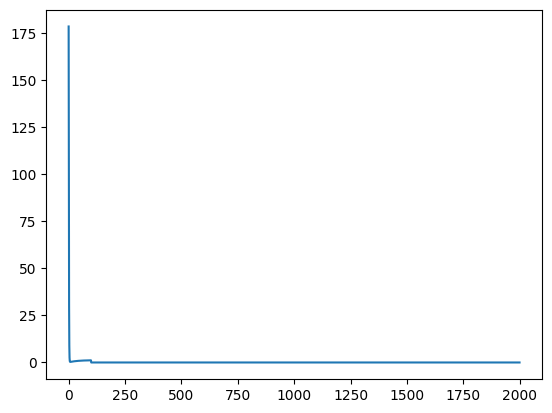

In [ ]:
import matplotlib.pyplot as plt
plt.plot(replay_buffer.action[:2000])

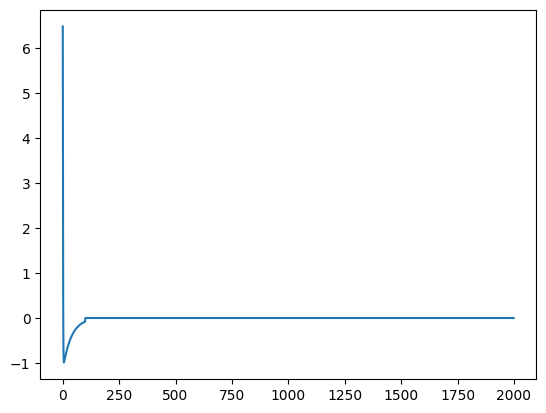

In [ ]:
plt.plot(replay_buffer.state[:2000,0], label='error')


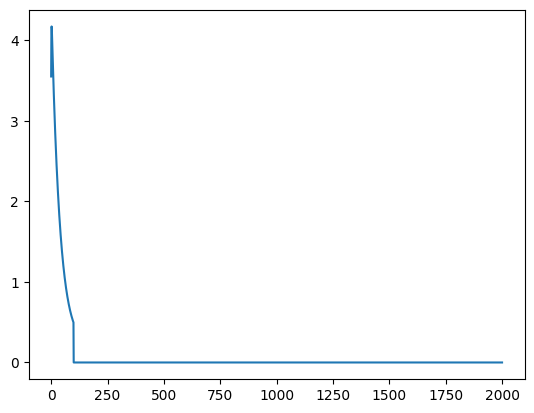

In [ ]:
plt.plot(replay_buffer.state[:2000,1], label='Integral')

In [ ]:
from ray.rllib.utils.torch_utils import convert_to_torch_tensor
import numpy as np

In [ ]:
10+np.random.randn()

9.734897202107904

In [ ]:
with torch.no_grad():
    policy.actor.l3.weight[0]= 2 * policy.actor.l3.weight[0][0].abs()